### Introduction to Hedging

**Define hedging in finance:**
Hedging in finance is a strategy used to reduce or eliminate the risk of adverse price movements in an asset. It involves taking an offsetting position in a related security, such as futures contracts, options, or stocks, to mitigate potential losses, similar to how insurance works in everyday life.

**Explain traditional hedging strategies:**
Traditional hedging strategies include:
- **Futures Contracts**: Agreements to buy or sell an asset at a future date at a price agreed upon today, used to lock in prices and protect against price fluctuations.
- **Options Contracts**: Contracts that give the holder the right to buy (call option) or sell (put option) an asset at a specified price before a certain date, used to protect against stock price declines.
- **Asset Diversification**: Investing in a variety of assets to reduce exposure to any single asset or risk.
- **Currency Hedging**: Using financial instruments to protect against changes in exchange rates, important for multinational operations.

**Discuss the importance of hedging in managing financial risk:**
Hedging is crucial for:
- Stabilizing income and cash flows.
- Protecting investments from major losses.
- Allowing for more certain future planning.
- Reducing portfolio volatility and improving long-term performance.

### Introduction to Deep Hedging

**Define deep hedging and its difference from traditional hedging:**
Deep hedging uses deep learning and neural networks to manage risk, adapting to new market conditions and handling complex data sets beyond traditional methods' capabilities.

**Introduce the concept of using neural networks in hedging strategies:**
Neural networks process and learn from large data sets to identify optimal hedging strategies, considering a wide range of market scenarios beyond historical data.

**Discuss the advantages of deep hedging:**
Advantages of deep hedging include:
- **Adaptability**: Adjusts to new market conditions and information.
- **Complexity Handling**: Understands complex relationships between financial instruments and market factors.
- **Cost Efficiency**: Identifies more efficient hedging strategies, potentially reducing hedging costs.
- **Risk Reduction**: Offers superior protection against extreme market events by considering a wider range of outcomes and scenarios.


# 7CCMFM18 Machine Learning
King's College London <br>
Academic year 2022-2023 <br>
Lecturer: Mario Martone

## Example: Deep Hedging in the Black-Scholes Model

Let us first import the necessary libraries and functions, and set plotting style.

In [1]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
import tensorflow.keras as keras
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
plt.style.use('ggplot')

We define auxiliary functions related to the Black-Scholes model, computing call option prices and delta under the model.

In [2]:
# Black-Scholes formula to calculate the price of a European call option.def BlackScholes(S0,r,sigma,T,K):
# Calculate d1 and d2 parameters used in the Black-Scholes formula.
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    d2 = d1 - sigma * np.sqrt(T)
# Return the price of the call option.
    return norm.cdf(d1) * S0 - norm.cdf(d2) * K * np.exp(-r*T)
#callprice = BlackScholes(S0,0,sigma,1,K)
# Function to calculate the delta of a European call option, which is the
# rate of change of the option's price with respect to changes in the underlying asset's price.
def BlackScholesCallDelta(S0,r,sigma,T,K):
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    return norm.cdf(d1)

We construct a price process $S = (S_t)_{t=0}^T$ as follows:
\begin{equation*}
S_t = S_0 \exp\bigg(\mu\frac{t}{T}+\sigma \sum_{i=1}^t \xi_i\bigg), \quad t = 0,1,\ldots,T,
\end{equation*}
where $\mu>0$, $\sigma>0$ and $S_0>0$ are constants, and $\xi_1,\ldots,\xi_T$ are mutually independent $N(0,\frac{1}{T})$-distributed random variables. When $T \rightarrow \infty$, the process $S$ approximates the continuous-time Black-Scholes price process
\begin{equation*}
S^{\mathrm{BS}}_t = S_0 \exp(\mu t + \sigma W_t), \quad t \in [0,1],
\end{equation*}
where $W = (W_t)_{t \in [0,1]}$ is a standard Brownian motion.

Next, we set the parameter values:

In [3]:
mu = 0.1  # Drift rate
sigma = 0.5  # Volatility
T = 100  # Time horizon
S_0 = 1  # Initial stock price

We generate $N$ independent samples $S^0,\ldots,S^{N-1}$ of the price path $S = (S_t)_{t=0}^T$ and store them in an $N \times (T+1)$ array.

In [4]:
N = 100000  # Number of simulation paths
xi = npr.normal(0, np.sqrt(1 / T), (N, T))  # Generate random fluctuations
W = np.apply_along_axis(np.cumsum, 1, xi) # Cumulative sum to simulate Brownian motion
W = np.concatenate((np.zeros((N, 1)), W),1)  # Add starting point
drift = np.linspace(0, mu , T + 1)  # Create a drift vector
drift = np.reshape(drift, (1, T + 1)  # Reshape for compatibility)
drift = np.repeat(drift, N, axis=0)  # Repeat for all simulation paths
S = S_0 * np.exp(drift + sigma * W)  # Simulate stock price paths

For future use, we compute an $N\times T$ array containing differenced prices.

In [5]:
dS = np.diff(S, 1, 1) # Calculate daily changes in stock prices

We also create a list of matrices
\begin{equation*}
\boldsymbol{X} :=\begin{bmatrix}
\begin{bmatrix}
0 & S^0_0 \\
0 & S^1_0 \\
\vdots & \vdots\\
0 & S^{N-1}_0
\end{bmatrix},
\begin{bmatrix}
\frac{1}{T} & S^0_1 \\
\frac{1}{T} & S^1_1 \\
\vdots & \vdots\\
\frac{1}{T} & S^{N-1}_1
\end{bmatrix},
\ldots,
\begin{bmatrix}
\frac{T-1}{T} & S^0_{T-1} \\
\frac{T-1}{T} & S^1_{T-1} \\
\vdots & \vdots\\
\frac{T-1}{T} & S^{N-1}_{T-1}
\end{bmatrix}
\end{bmatrix}
\end{equation*}
which will form the features of our training data.

In [6]:
tim = np.linspace(0, 1, T+1) # Time vector for plotting
X = []# List to hold time and stock price data for neural network input
for i in range(T):
    timv = np.repeat(tim[i],N)
    timv = np.reshape(timv,(N,1))
    Sv = np.reshape(S[:,i],(N,1))
    X.append(np.concatenate((timv,Sv),1)) # Create input array for each time step

Before proceeding further, it is useful to plot a couple of price paths in our data set.

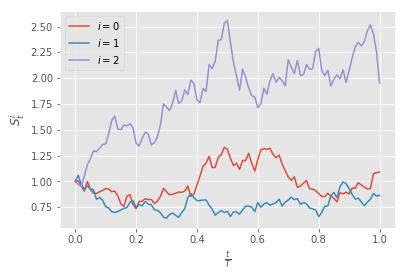

In [7]:
plt.plot(tim,S[0],label="$i=0$")
plt.plot(tim,S[1],label="$i=1$")         
plt.plot(tim,S[2],label="$i=2$")
plt.xlabel(r"$\frac{t}{T}$")  # Normalize time for x-axis
plt.ylabel(r"$S^i_t$")  # Stock price at time t for path i
plt.legend()
plt.show()

Our aim is to hedge the call option
\begin{equation*}
(S_T - K)^+,
\end{equation*}
written on $S$,
that is, develop an adapted and self-financing trading strategy in the underlying stock so that its terminal wealth matches the option payoff as closely as possible. Such a trading strategy is specified by its initial wealth $x \in \mathbb{R}$ and position $\gamma_t$ in the underlying stock at time $t$ for any $t = 0,1,\ldots,T-1$. By adaptedness, $\gamma_t$ must be a function of the past prices $S_t,S_{t-1},\ldots,S_0$ only. Assuming zero interest rate, by the self-financing property, the terminal wealth of the strategy can be expressed as
\begin{equation*}
V_T = x + \sum_{t=1}^T \gamma_{t-1} (S_t-S_{t-1}).
\end{equation*}
Then the option hedger's profit and loss is
\begin{equation*}
\mathrm{PnL} = V_T - (S_T - K)^+,
\end{equation*}
Note that, with $x$ and $S_0$ fixed, we can view $\mathrm{PnL}$ as a function of the trading strategy $\gamma_{0},\gamma_1,\ldots,\gamma_{T-1}$ and the price increments $S_1-S_0,S_2-S_1,\ldots,S_T-S_{T-1}$, since
\begin{equation*}
\mathrm{PnL}(\gamma_{0},\gamma_1,\ldots,\gamma_{T-1},;S_1-S_0,S_2-S_1,\ldots,S_T-S_{T-1}) = x + \sum_{t=1}^T \gamma_{t-1} (S_t-S_{t-1}) - \bigg(S_0 + \sum_{t=1}^T (S_t-S_{t-1}) -K \bigg)^+.
\end{equation*}

The key insight of <b>deep hedging</b> is to represent the trading strategy as a neural network, whose inputs are the available market data and output is the hedging position, that is
\begin{equation*}
\gamma_t = f_t(S_{t},S_{t-1},\ldots,S_0),
\end{equation*}
where $f_t$ is a neural network for any $t = 0,1,\ldots,T-1$. Here, since we know that $S$ is a Markov process, we can simplify the problem slightly (although this is not necessary in general) by seeking a single network $f : [0,1]\times \mathbb{R} \rightarrow \mathbb{R}$ such that
\begin{equation*}
\gamma_t = f\bigg(\frac{t}{T},S_t\bigg), \quad t = 0,1,\ldots,T-1.
\end{equation*}
However, to evaluate $\mathrm{PnL}$, we need all values $f(0,S_0),f(\frac{1}{T},S_T),\ldots,f(\frac{T-1}{T},S_{T-1})$, so we need to create a large hedging network $F$ by concatenating $f(\frac{t}{T},S_t)$ over $t = 0,1,\ldots,T-1$, so that our feedforward network is the map
\begin{equation*}
F :
\begin{bmatrix}
 (0, S_0) & \Big(\frac{1}{T},S_1\Big) & \cdots & \Big(\frac{T-1}{T},S_{T-1}\Big)\end{bmatrix} \mapsto \begin{bmatrix}
f(0,S_0) & f\Big(\frac{1}{T},S_T\Big) & \cdots & f\Big(\frac{T-1}{T},S_{T-1}\Big)
\end{bmatrix}.
\end{equation*}
This network is not fully connected and it has shared layers (since $f$ is repeated), so we need to use the <b>Functional API</b> in Keras to specify it. For $f$, we specify
\begin{equation*}
f \in \mathcal{N}_4(2,100,100,100,1; \mathrm{RELU},\mathrm{RELU},\mathrm{RELU},\mathrm{Sigmoid}),
\end{equation*}
where we choose $\mathrm{Sigmoid}$ due to the financial intuition that the hedging position should be between $0$ and $1$. (This choice helps training, but is not really necessary.)

In [8]:
# Neural network structure
inputs = [] # List to hold input layers
predictions = []# List to hold output layers

# Define layers of the neural network
layer1 = keras.layers.Dense(100, activation='relu')
layer2 = keras.layers.Dense(100, activation='relu')
layer3 = keras.layers.Dense(100, activation='relu')
layer4 = keras.layers.Dense(1, activation='sigmoid')

# Construct neural network for each time step
for i in range(T):
    sinput = keras.layers.Input(shape=(2,))
    x = layer1(sinput)
    x = layer2(x)
    x = layer3(x)
    sprediction = layer4(x)
    inputs.append(sinput)
    predictions.append(sprediction)
    
predictions = keras.layers.Concatenate(axis=-1)(predictions) # Combine all predictions
model = keras.models.Model(inputs=inputs, outputs=predictions) # Create model
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2)]          0                                            
_____________

We train $f$, and subsequently $F$, so that quadratic hedging error, that is, $\mathrm{PnL}^2$ is empirically minimised. To this end, we define loss function
\begin{equation*}
\ell\big((\hat{y}_0,\hat{y}_1,\ldots,\hat{y}_{T-1}),(y_0,y_1,\ldots,y_{T-1})\big) := \mathrm{PnL}(\hat{y}_0,\hat{y}_1,\ldots,\hat{y}_{T-1};y_0,y_1,\ldots,y_{T-1})^2.
\end{equation*}
We fix $x$ as the corresponding Black-Scholes call price $\mathrm{BS}(S_0,K,1)$. The loss function $\ell$ is a custom one, so it needs to be implemented separately. When implementing it, it is important that we use functions from the <b>backend</b> of Keras; they are functions that TensorFlow is able to differentiate algorithmically. 

In [0]:
# Hedging loss function for training the neural network
K = 1# Strike price
callprice = BlackScholes(S_0, 0, sigma, 1, K)# Call option price using Black-Scholes
# Custom loss function for hedging
def loss_call(y_true,y_pred):
    return (callprice + kb.sum(y_pred * y_true,axis=-1) - kb.maximum(S_0 + kb.sum(y_true,axis=-1) - K,0.))**2

We train now the network using Adam optimisation algorithm, minibatch size $100$, doing $4$ epochs. Note that in training,
\begin{equation*}
\hat{y}_t = f\Big(\frac{t}{T},S^i_t\Big), \quad y_t = S^i_{t+1} - S^i_{t}, \quad t=0,1,\ldots,T-1.
\end{equation*}
Technically, the features are provided using the list $\boldsymbol{X}$ constructed above.

In [10]:
epochs = 4 # Number of epochs for training
model.compile(optimizer='adam', loss=loss_call, metrics=[])# Compile model with custom loss
model.fit(X,dS,batch_size=100,epochs=epochs)# Train the model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 100000 samples
Epoch 1/4
100000/100000 [==============================] - 36s 356us/sample - loss: 0.0016
Epoch 2/4
100000/100000 [==============================] - 30s 301us/sample - loss: 3.5289e-04
Epoch 3/4
100000/100000 [==============================] - 30s 300us/sample - loss: 3.4036e-04
Epoch 4/4
100000/100000 [==============================] - 30s 304us/sample - loss: 3.3498e-04


Since for large $T$ the price process $S$ (under time rescaling) is close to the Black-Scholes price process $S^{\mathrm{BS}}$, the hedging strategy $\gamma_t = f(\frac{t}{T},S_t)$ should be close to the (continuous-time) Black-Scholes delta hedging strategy
\begin{equation*}
\gamma^\mathrm{BS}_t = \frac{\partial}{\partial S}\mathrm{BS}\bigg(S_t,K,1-\frac{t}{T}\bigg),
\end{equation*}
which amounts to perfect replication, $\mathrm{PnL}=0$.

Let us study if this is the case:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


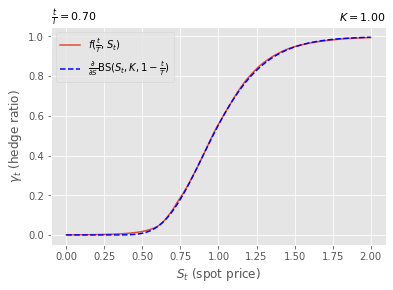

In [11]:
# Evaluating the trained model's performance
t = 0.7 # Specific time for evaluating hedging strategy
tStest = []
Sval = np.linspace(0,2,num=T) # Range of stock prices for evaluation
for i in range(T):
    z = (t,Sval[i])
    z = np.reshape(z,(1,2))
    tStest.append(z)

Delta_learn = np.reshape(model.predict(tStest), (T,))
Delta_BS = BlackScholesCallDelta(Sval, 0, sigma, 1-t, K)
plt.plot(Sval, Delta_learn, label=r"$f(\frac{t}{T},S_{t})$")
plt.plot(Sval, Delta_BS, "b--", label=r"$\frac{\partial}{\partial S}\mathrm{BS}(S_t,K,1-\frac{t}{T})$")
plt.xlabel(r"$S_t$ (spot price)")
plt.ylabel(r"$\gamma_t$ (hedge ratio)")
plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
plt.title(r'$K=$%1.2f' % K, loc='right', fontsize=11)
plt.legend()
plt.show()

We have "derived" the Black-Scholes delta hedge by deep learning! Note that this is <b>unsupervised learning</b>: we did not tell the network $f$ what the Black-Scholes delta hedge is, it learned it by PnL optimisation.